In [1]:
%load_ext autoreload
%autoreload 2

import torch
import transformers
import yaml
from src.utils import model_utils
from src.utils import quantized_model
from src.model import llama
from transformers import LlamaForCausalLM as OrigLlama
import os
from src import data
import tqdm 
import torch

In [2]:
# !export CUDA_VISIBLE_DEVICES=0,1
# !export CUDA_LAUNCH_BLOCKING=1
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# torch.distributed.init_process_group(backend='nccl')

In [ ]:
#config
ft_n_train = 128
ft_n_val = 32
ft_dataset = "pajama"
base_model = "meta-llama/Llama-2-7b-hf"
seqlen = 4096
batch_size = 1
per_device_train_batch_size = 2
use_embedding = False
cache_logits_path = f"temp/cache_logits_{ft_n_train}_{ft_n_val}.pt"

In [4]:
orig_model = OrigLlama.from_pretrained(base_model,
                                       device_map="auto", torch_dtype=torch.float32)



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
overall_data:list[torch.FloatTensor] = data.get_loaders(ft_dataset, nsamples = ft_n_train+ft_n_val
                                  , model = base_model, train_test = "train",
                                  seqlen=seqlen)

overall_data = torch.stack([_[0][0] for _ in overall_data])

Loading Red Pajama: 100%|██████████| 24/24 [00:01<00:00, 12.82it/s]


In [ ]:
@torch.no_grad()
def calculate_logits(model: llama.LlamaForCausalLM, devset, batch_size):
    logits = []
    for i in tqdm.tqdm(range(len(devset) // batch_size), desc = "Calculating logits"):
        logits.append(
            model(devset[i * batch_size:(i + 1) *
                         batch_size].cuda())['logits'].cpu())
    logits = torch.concat(logits, dim=0)
    return logits

In [7]:
if os.path.exists(cache_logits_path):
    overall_out = torch.load(cache_logits_path)
else:
    overall_out = calculate_logits(orig_model,overall_data, batch_size)
    torch.save(overall_out, cache_logits_path)

In [13]:
overall_out.shape

torch.Size([288, 4095, 32000])

In [9]:
overall_out = overall_out[:, :-1].contiguous().softmax(dim=-1).float()

In [10]:
overall_out

tensor([[[2.9361e-09, 1.5627e-09, 1.2552e-05,  ..., 6.4221e-08,
          1.7284e-08, 3.9558e-08],
         [2.8027e-10, 2.6807e-10, 3.8141e-05,  ..., 8.4279e-08,
          3.0857e-09, 3.9223e-08],
         [1.1124e-10, 1.8740e-10, 3.0101e-05,  ..., 2.3399e-08,
          3.0280e-10, 5.1523e-09],
         ...,
         [3.9986e-11, 6.1179e-11, 1.3312e-03,  ..., 3.3386e-09,
          4.4961e-10, 2.0344e-09],
         [2.4797e-12, 2.1652e-12, 1.0475e-07,  ..., 2.1769e-12,
          1.2719e-11, 3.1388e-12],
         [2.2948e-11, 4.9620e-12, 2.5483e-06,  ..., 6.4511e-10,
          5.8581e-09, 6.8206e-10]],

        [[1.0061e-09, 1.4295e-10, 1.3197e-05,  ..., 2.6846e-08,
          1.9731e-09, 5.9343e-09],
         [1.4114e-10, 5.5605e-10, 1.3946e-05,  ..., 3.2076e-09,
          7.9734e-10, 3.6518e-09],
         [5.6694e-11, 3.2917e-10, 4.2352e-05,  ..., 8.4615e-10,
          1.2762e-09, 8.3645e-10],
         ...,
         [1.7560e-12, 5.1188e-13, 1.7436e-06,  ..., 2.9868e-10,
          6.465

In [11]:

del orig_model

In [12]:
from src.utils import utils



utils.clean()

In [14]:
model = llama.LlamaForCausalLM.from_pretrained("/data/lliu/huffman/models/meta-llama/Llama-2-7b-hf/compressed_hf/run_38",
                                               device_map="auto",
                                                  torch_dtype=torch.float32,
                                                    low_cpu_mem_usage=True)

# model = model_utils.get_llama("meta-llama/Llama-2-7b-hf",
#                                device_map="auto",
#                                 dtype=torch.float32)
                          
    

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [22]:
with torch.no_grad():
    non_trained_outs = model(overall_data[[5]].cuda())

In [19]:
overall_out[[0]].shape

torch.Size([1, 4095, 32000])

In [21]:
non_trained_outs.logits.shape

torch.Size([1, 4096, 32000])

In [23]:
#custom kld loss
def custom_kld_loss(outputs, labels, num_items_in_batch):
    # print(outputs['logits'].shape)
    logits = outputs['logits'][:,:-1,:].contiguous()
    # print(logits.shape, labels.shape, num_items_in_batch)
    
    #take the cross entropy loss along the last dimension
    #labels are of the same shape as logits
    loss = -torch.sum(labels * torch.log_softmax(logits, dim=-1), dim=-1)
    loss = loss.mean()
    return loss

custom_kld_loss(non_trained_outs, overall_out[[5]].cuda(), 1)

tensor(16.4344, device='cuda:0')

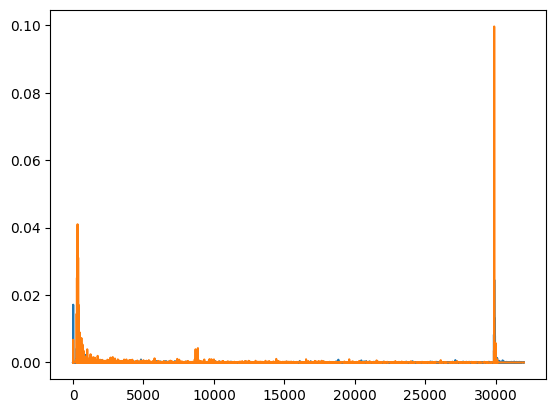

In [27]:
import matplotlib.pyplot as plt

plt.plot(non_trained_outs.logits[0,0].softmax(dim=-1).cpu().numpy())
plt.plot(overall_out[[5]][0,0].cpu().numpy())

In [ ]:
overall_out

tensor([[[2.9361e-09, 1.5627e-09, 1.2552e-05,  ..., 6.4221e-08,
          1.7284e-08, 3.9558e-08],
         [2.8027e-10, 2.6807e-10, 3.8141e-05,  ..., 8.4279e-08,
          3.0857e-09, 3.9223e-08],
         [1.1124e-10, 1.8740e-10, 3.0101e-05,  ..., 2.3399e-08,
          3.0280e-10, 5.1523e-09],
         ...,
         [3.9986e-11, 6.1179e-11, 1.3312e-03,  ..., 3.3386e-09,
          4.4961e-10, 2.0344e-09],
         [2.4797e-12, 2.1652e-12, 1.0475e-07,  ..., 2.1769e-12,
          1.2719e-11, 3.1388e-12],
         [2.2948e-11, 4.9620e-12, 2.5483e-06,  ..., 6.4511e-10,
          5.8581e-09, 6.8206e-10]],

        [[1.0061e-09, 1.4295e-10, 1.3197e-05,  ..., 2.6846e-08,
          1.9731e-09, 5.9343e-09],
         [1.4114e-10, 5.5605e-10, 1.3946e-05,  ..., 3.2076e-09,
          7.9734e-10, 3.6518e-09],
         [5.6694e-11, 3.2917e-10, 4.2352e-05,  ..., 8.4615e-10,
          1.2762e-09, 8.3645e-10],
         ...,
         [1.7560e-12, 5.1188e-13, 1.7436e-06,  ..., 2.9868e-10,
          6.465

In [18]:
from torch.utils.data import Dataset
from typing import Tuple
import torch.nn as nn

class SimpleDataset(Dataset):

    def __init__(self, inputs, soft_labels):
        self.inputs = inputs
        self.soft_labels = soft_labels
    

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return {
            'input_ids': self.inputs[idx],
            'labels': self.soft_labels[idx],
        }
    
def make_datasets(X:torch.FloatTensor, Y:torch.FloatTensor, n_val:int) -> Tuple[Dataset, Dataset]:
    

    #make the indices
    idxs = torch.randperm(len(X))
    train_idxs = idxs[:-n_val]

    train_ds = SimpleDataset(X[train_idxs], Y[train_idxs])
    valid_ds = SimpleDataset(X[idxs[-n_val:]], Y[idxs[-n_val:]])
    return train_ds, valid_ds

traindataset, validdataset = make_datasets(overall_data, overall_out, ft_n_val)

In [19]:
len(traindataset), len(validdataset)

(16, 8)

In [20]:
#train the model on the dataset with transformers trainer

trainer = transformers.Trainer(
    model=model,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=per_device_train_batch_size,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        fp16=True,
        logging_steps=1,
        output_dir="./output",
        num_train_epochs=2,
        save_total_limit=3,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        # eval_steps=100,
        # per_device_train_batch_size=32,
        load_best_model_at_end=True,
        #add a tqdm progress bar
        #set the lr to 1e-5
        learning_rate=1e-5,
        warmup_steps=100,
        lr_scheduler_type="cosine_with_restarts",
        lr_scheduler_kwargs={"num_cycles": 5},
        dataloader_pin_memory=False,
        #set the logging dir to ./logs
        logging_dir="./logs",
        #log to wandb
        report_to="wandb",
        run_name="llama-2-7b-hf-soft",
        eval_on_start = True,
    ),
    train_dataset=traindataset,
    eval_dataset=validdataset,
    compute_loss_func=custom_kld_loss,
)

trainer.train()



/home/lliu/miniconda3/envs/NoWAC-VQ/lib/python3.13/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: m6481 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
0,No log,1.873177
1,1.932400,1.870640
2,1.638000,1.861166


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


TrainOutput(global_step=16, training_loss=2.0369246751070023, metrics={'train_runtime': 138.0796, 'train_samples_per_second': 0.232, 'train_steps_per_second': 0.116, 'total_flos': 110652316188672.0, 'train_loss': 2.0369246751070023, 'epoch': 2.0})

In [21]:
prev_logits = temp_out["logits"].contiguous().softmax(dim=-1).float()
prev_logits

tensor([[[2.4570e-07, 1.0009e-05, 7.6252e-04,  ..., 4.1097e-07,
          1.6429e-07, 1.1824e-06],
         [8.1737e-11, 2.8434e-11, 1.3481e-05,  ..., 3.7359e-10,
          1.0008e-09, 8.9002e-10],
         [1.2812e-10, 8.4170e-11, 2.1571e-05,  ..., 4.8376e-09,
          2.5928e-09, 1.4138e-09],
         ...,
         [5.9615e-12, 1.5918e-11, 9.1196e-07,  ..., 9.6534e-11,
          1.9837e-10, 3.1553e-10],
         [1.4834e-10, 4.9392e-11, 1.6311e-06,  ..., 3.8183e-10,
          1.6049e-10, 7.7437e-11],
         [1.9405e-10, 1.5238e-10, 6.4399e-05,  ..., 1.4155e-09,
          5.2544e-10, 1.8255e-10]]], device='cuda:0')

In [25]:
with torch.no_grad():
    temp_out = model(overall_data[[0]].cuda())
    print(temp_out["logits"].contiguous().softmax(dim=-1).float()[0,0])

tensor([2.7338e-07, 1.0782e-05, 7.6258e-04,  ..., 4.5604e-07, 1.7242e-07,
        1.2228e-06], device='cuda:0')


In [23]:
overall_out[[0]]

tensor([[[2.6485e-10, 1.4232e-08, 4.8993e-05,  ..., 1.4750e-08,
          4.8198e-09, 2.6300e-09],
         [6.9249e-11, 7.0647e-11, 1.5791e-05,  ..., 3.2829e-10,
          2.1836e-09, 3.5391e-10],
         [4.9343e-11, 1.3910e-10, 1.5000e-05,  ..., 4.9455e-09,
          1.6772e-09, 5.6072e-10],
         ...,
         [2.3104e-13, 1.9384e-13, 3.8083e-07,  ..., 2.5601e-12,
          2.5149e-14, 2.0033e-12],
         [4.0694e-14, 2.1865e-14, 2.1472e-07,  ..., 2.7358e-13,
          9.1159e-15, 1.8203e-13],
         [2.0762e-12, 2.6297e-12, 5.5321e-07,  ..., 5.5716e-11,
          5.3207e-13, 1.6526e-12]]])

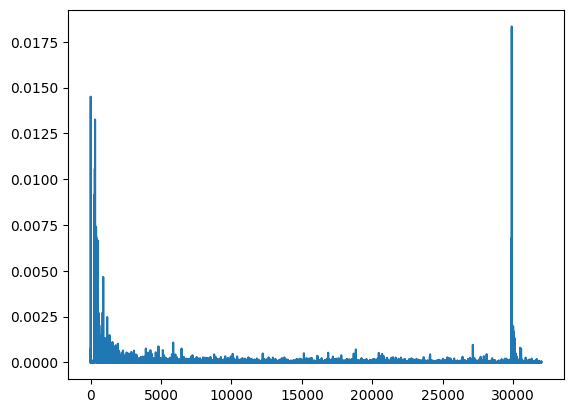

In [27]:
import matplotlib.pyplot as plt
plt.plot(temp_out["logits"].contiguous().softmax(dim=-1).float()[0,0].cpu().numpy())

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7099db57cc20>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7092e821bee0, raw_cell="plt.plot(overall_out[[0]][0,0].cpu().numpy())" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2B164.67.204.101/data/lliu/huffman/test_train.ipynb#Y131sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

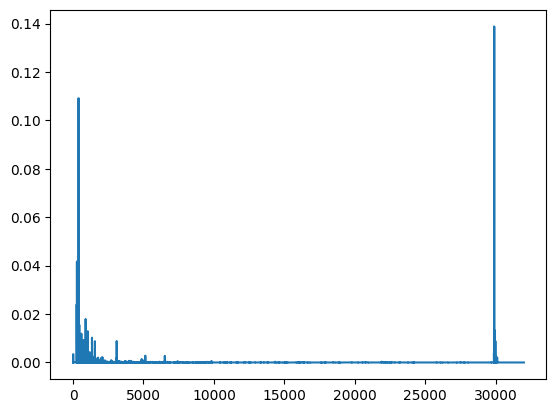

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7099db57cc20>> (for post_run_cell), with arguments args (<ExecutionResult object at 7092e8239c10, execution_count=29 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7092e821bee0, raw_cell="plt.plot(overall_out[[0]][0,0].cpu().numpy())" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2B164.67.204.101/data/lliu/huffman/test_train.ipynb#Y131sdnNjb2RlLXJlbW90ZQ%3D%3D> result=[<matplotlib.lines.Line2D object at 0x7092dcb46d50>]>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [29]:
plt.plot(overall_out[[0]][0,0].cpu().numpy())

In [24]:
model(valset[0]["input_ids"][...,:-2].cuda(),
      labels=valset[0]["input_ids"][...,1:].cuda()[...,:-1]  # shift labels
      ).loss

tensor(13.3660, device='cuda:0', grad_fn=<ToCopyBackward0>)

In [6]:
import glob
import tqdm
import torch

In [7]:
paths = glob.glob("/data/lliu/huffman/models/meta-llama/*/hessianDiags/seed_0/pajama/128/*/*.pt")
print(len(paths))

1848


In [ ]:
for p in tqdm.tqdm(paths):
    hessianDiag = torch.load(p)
    if "hessianDiag" in hessianDiag:
        continue
    torch.save({"hessianDiag": hessianDiag["hessian"]}, p)

100%|██████████| 1848/1848 [00:01<00:00, 979.71it/s] 


: 

In [9]:
torch.load(p)

{'hessianDiag': tensor([0.0067, 0.0076, 0.0071,  ..., 0.0070, 0.0077, 0.0074], device='cuda:1',
        dtype=torch.float16)}

In [ ]:
class A:
    
    def __init__(self):
        self.a = 1
        self.b = 2
        self.c = 3
        
    def fn1(self):
        print("fn1_A")
        
    @classmethod
    def fn1_static(cls):
        c = cls()
        c.fn1()
        return c
    
class B(A):
    
    def __init__(self):
        super().__init__()
        print("initializing B")
        self.d = 4
        
    def fn1(self):
        print("fn1_B")
        
B.fn1_static()
    


initializing B
fn1_B


: 